# Bank of England - Data Scientist Interview

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import io
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures 
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('gutenberg')
from nltk.collocations import TrigramCollocationFinder 
from nltk.metrics import TrigramAssocMeasures 
from nltk.text import Text

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /Users/Mada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Mada/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package gutenberg to /Users/Mada/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


### Pre-processing

In [2]:
def extract_text_from_first_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    with open(pdf_path, 'rb') as fh:
        for pageNumber, page in enumerate(PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True)):
            if (pageNumber != 0) & (pageNumber != 8) & (pageNumber != 9):
                page_interpreter.process_page(page)
        text = fake_file_handle.getvalue()
    # close open handles
    converter.close()
    fake_file_handle.close()
    if text:
        return text
    
def extract_text_from_rest_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    with open(pdf_path, 'rb') as fh:
        for pageNumber, page in enumerate(PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True)):
            if (pageNumber != 0):
                page_interpreter.process_page(page)
        text = fake_file_handle.getvalue()
    # close open handles
    converter.close()
    fake_file_handle.close()
    if text:
        return text

In [3]:
cyborg = extract_text_from_first_pdf("cyborg-supervision-speech-by-james-proudman.pdf")
ai = extract_text_from_rest_pdf("managing-machines-the-governance-of-artificial-intelligence-speech-by-james-proudman.pdf")
sca = extract_text_from_rest_pdf("supervisor-centred-automation-the-role-of-human-centred-automation-speech-by-james-proudman.pdf")

In [4]:
data = [[cyborg], [ai], [sca]]
df = pd.DataFrame(data, columns = ['Speech']) 

In [91]:
import dash_html_components as html
def make_dash_table(df):
    """ Return a dash definition of an HTML table for a Pandas dataframe """
    table = []
    for index, row in df.iterrows():
        html_row = []
        for i in range(len(row)):
            html_row.append(html.Td([row[i]]))
        table.append(html.Tr(html_row))
    return table

### Data cleaning 1

In [6]:
df['Speech'][0]

'     All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 2  2  I. Introduction  Recognising faces comes instinctively to humans. Until fairly recently, however, it proved beyond the ability of computers. Advances in artificial intelligence (AI) - the use of a machine to simulate human behaviour – and its subset, machine learning (ML) – in which a machine teaches itself to perform tasks – are now making facial recognition software much more widely available. You might even use it to access your bank account.    Because it is so easy for us but so hard for computers, facial recognition is a good illustration of the challenges faced in developing AI. Enabling a machine to teach itself to recognise a face requires sophisticated algorithms that can learn from data. Advances in computational power and algorithmic techniques are helping machines become more human and super-human like. ML also requires lots of data from which to learn: data ar

In [7]:
df['Speech'][0] = df['Speech'][0].replace('\x0c', '')
df['Speech'][0] = df['Speech'][0].replace('\xa0', '')
# remove the chapter headers
df['Speech'][0] = re.sub(r'(\s((IX|IV|V?I{1,3})+)\.\s)(.*?)(\s{2,})', '', df['Speech'][0])

In [8]:
# remove the footer
df['Speech'][0] = re.sub(r'All speeches.*?aspx', '', df['Speech'][0])
df['Speech'][0] = re.sub(r'Figure.*?\d\:?', '', df['Speech'][0])

In [9]:
# remove page numbers
df['Speech'][0] = re.sub(r'\d\s{1,2}\d', '', df['Speech'][0])

In [10]:
# remove the footnotes
df['Speech'][0] = re.sub(r'(\s{3,}?(\d)(.*?)(\d)?(\s*)?\s{2,})', '', df['Speech'][0])

In [11]:
# add space after full stop
df['Speech'][0] = re.sub('\.(?!\s|$)', '. ', df['Speech'][0])

In [12]:
# remove whitespaces and numbers
df['Speech'][0] = re.sub('\s*?\d*?\s{1,}', ' ', df['Speech'][0])

### Data cleaning 2

In [13]:
df['Speech'][1]

'  All speeches are available online at www.bankofengland.co.uk/publications/Pages/speeches/default.aspx 2  2   Introduction  Consider the well-known story of one Big Tech company’s attempt to use artificial intelligence to improve the efficiency of its staff recruitment. The machine learning system reviewed job applicants’ CVs with the aim of automating the search for top talent. The company’s experimental hiring tool used artificial intelligence to give job candidates scores ranging from one to five stars. Within a year, the company realised its new system was not rating candidates for software developer jobs and other technical posts in a gender-neutral way. That is because the computer models were trained to vet applicants by observing patterns in CVs submitted to the company over a 10-year period. Most came from men, a reflection of male dominance across the technology industry. In effect, the company’s system taught itself that male candidates were preferable. It penalised CVs th

In [14]:
df['Speech'][1] = df['Speech'][1].replace('\x0c', '')
df['Speech'][1] = df['Speech'][1].replace('\xa0', '')

In [15]:
# remove the footer
df['Speech'][1] = re.sub(r'All speeches.*?aspx', '', df['Speech'][1])

In [16]:
# remove page numbers
df['Speech'][1] = re.sub(r'\d\s{1,2}\d', '', df['Speech'][1])

In [17]:
# remove the footnotes
df['Speech'][1] = re.sub(r'\s{2,}?(\d).*?‘.*?’', '', df['Speech'][1])

In [18]:
# add space after full stop
df['Speech'][1] = re.sub('\.(?!\s|$)', '. ', df['Speech'][1])

In [19]:
# remove whitespaces and numbers
df['Speech'][1] = re.sub('\s*?\d*?\s{1,}', ' ', df['Speech'][1])

### Data cleaning 3

In [20]:
df['Speech'][2]

'     All speeches are available online at www.bankofengland.co.uk/news/speeches 2  2   INTRODUCTION  It’s March 2030.  The phone rings1. It is the PRA CEO’s office.  “How worried should we be about BigBank and SmallBank’s vulnerability to the widget market?” “Give me an hour” you say…  Accessing the shared data repository from your laptop, you extract BigBank’s and SmallBank’s current credit and derivative exposures to the widget market, and double-check there are no other regulated entities with exposures as large.  You then estimate the impacts of a 20% fall in widget prices on last night’s current and projected capital ratios for the two banks, and then – with an eye to informing  macro-prudential effects - for the system as a whole.  You calculate indirect exposures by estimating the effect a 20% fall in widget prices will have on BigBank’s and SmallBank’s counterparties. To complement your quantitative analysis, you analyse various textual sources - including recent internal anal

In [21]:
df['Speech'][2] = df['Speech'][2].replace('\x0c', '')
df['Speech'][2] = df['Speech'][2].replace('\xa0', '')

In [22]:
# remove the footer
df['Speech'][2] = re.sub(r'All speeches.*?speeches', '', df['Speech'][2])

In [23]:
# remove page numbers
df['Speech'][2] = re.sub(r'\d\s{1,2}\d', '', df['Speech'][2])

In [24]:
# remove the footnotes
df['Speech'][2] = re.sub(r'\s{2,}?(\d).*?\s{2,}', '', df['Speech'][2])

In [25]:
# add space after full stop
df['Speech'][2] = re.sub('\.(?!\s|$)', '. ', df['Speech'][2])

In [26]:
# remove whitespaces and numbers
df['Speech'][2] = re.sub('\s*?\d*?\s{1,}', ' ', df['Speech'][2])

## Extractive Summary

In [27]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [28]:
len(word_embeddings)

400000

In [29]:
documents = []
for doc in df['Speech']:
    documents.append(sent_tokenize(doc))

In [30]:
documents[0][:5]

[' Recognising faces comes instinctively to humans.',
 'Until fairly recently, however, it proved beyond the ability of computers.',
 'Advances in artificial intelligence (AI) - the use of a machine to simulate human behaviour – and its subset, machine learning (ML) – in which a machine teaches itself to perform tasks – are now making facial recognition software much more widely available.',
 'You might even use it to access your bank account.',
 'Because it is so easy for us but so hard for computers, facial recognition is a good illustration of the challenges faced in developing AI.']

In [31]:
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [32]:
clean_documents = []
for document in documents:
    clean_doc = [(re.sub('[^a-zA-Z]', ' ', sent)) for sent in document]
    clean_doc = [sent.lower() for sent in clean_doc]
    clean_doc = [remove_stopwords(sent.split()) for sent in clean_doc]
    clean_documents.append(clean_doc)

In [33]:
clean_documents

[['recognising faces comes instinctively humans',
  'fairly recently however proved beyond ability computers',
  'advances artificial intelligence ai use machine simulate human behaviour subset machine learning ml machine teaches perform tasks making facial recognition software much widely available',
  'might even use access bank account',
  'easy us hard computers facial recognition good illustration challenges faced developing ai',
  'enabling machine teach recognise face requires sophisticated algorithms learn data',
  'advances computational power algorithmic techniques helping machines become human super human like',
  'ml also requires lots data learn data fuel powers data used train algorithms accurate predictions typically become',
  'hence advances ai often associated big data recent huge advances volume variety data available see',
  'sophistication algorithms volume data rise uses ai every day life expanding',
  'finance exception',
  'speech want explore impact ai advanced

In [34]:
doc_sentence_vectors = []

for doc in clean_documents:
    sentence_vectors = []
    for sent in doc:
        if len(sent) != 0:
            v = sum([word_embeddings.get(w, np.zeros((100,))) for w in sent.split()])/(len(sent.split())+0.001)
        else:
            v = np.zeros((100,))
        sentence_vectors.append(v)
    doc_sentence_vectors.append(sentence_vectors)

In [35]:
len(clean_documents[0])

130

In [37]:
doc_sentence_vectors[0][0]

array([ 0.12131574,  0.35353327,  0.7753329 ,  0.18450673,  0.07493703,
        0.24672166, -0.37021437, -0.1265407 ,  0.36059588, -0.32207918,
       -0.23816751,  0.14739752,  0.29553348, -0.04907819,  0.09458449,
        0.01792527, -0.15341632,  0.4635233 , -0.13508578, -0.0349646 ,
       -0.09764986, -0.07793   , -0.0029762 , -0.18217537,  0.37061447,
        0.2888804 , -0.16216676, -0.20888421,  0.06377164, -0.19265547,
        0.00577275,  0.31803042, -0.14024515, -0.19776066,  0.35675564,
       -0.19280303, -0.08648451, -0.03138972, -0.30759647, -0.13765927,
       -0.4791322 ,  0.11267728,  0.11911017, -0.31535995, -0.26942214,
        0.16389363,  0.44340137,  0.07158788, -0.3539559 , -0.20514257,
        0.29741773, -0.11439612,  0.12960108,  0.8623616 , -0.09912819,
       -0.9223479 ,  0.1325771 , -0.36743492,  0.33754244,  0.08994121,
        0.16085723,  0.66521615,  0.01688482, -0.20298482,  0.36371925,
        0.44131216,  0.13480103,  0.08270423, -0.02520265, -0.10

In [38]:
for index, doc in enumerate(documents):
    # similarity matrix
    sim_mat = np.zeros([len(doc), len(doc)])
    
    for i in range(len(doc)):
        for j in range(len(doc)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(doc_sentence_vectors[index][i].reshape(1,100), doc_sentence_vectors[index][j].reshape(1,100))[0,0]
        
    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph)
    
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(doc)), reverse=True)
    
    # Extract top 10 sentences as the summary
    print('Summary:')
    for t in range(5):
        print(ranked_sentences[t][1])
    print('-------' * 10)
    print('      ')

Summary:
So – along the same lines pursued by law firms for example – one big win is the ability to produce structured data from a range of sources, the analysis of which traditionally required significant manual effort.
For example, while ML models could alter banks’ trading and retail businesses – enabling them to make better decisions more quickly – the opacity, however, of these models may also make them more difficult for humans to understand.
At the macroeconomic level, changes in technology, including AI, could, over time, profoundly affect the nature of the financial services consumed and may result inchanges to the structure of the financial services industry.
A typical problem faced by supervisors, for example, is the ‘needle-in-a-haystack’ problem: if something is going wrong in a firm, it can be necessary to find out who in the firm made relevant decisions, based on what information, and why the checks and balances of the firm – the board, and second and third lines of defe

# Markov Chains - Auto-generated text

In [39]:
text = df['Speech'][0]

In [40]:
corpus = text.split()

In [41]:
def make_pairs(corpus):
    for i in range(len(corpus)-1):
        yield (corpus[i], corpus[i+1])
        
pairs = make_pairs(corpus)

In [42]:
word_dict = {}
for word_1, word_2 in pairs:
    if word_1 in word_dict.keys():
        word_dict[word_1].append(word_2)
    else:
        word_dict[word_1] = [word_2]

In [43]:
first_word = input()
chain = [first_word]
n_words = 15

data


In [44]:
for i in range(n_words):
    chain.append(np.random.choice(word_dict[chain[-1]]))

In [45]:
' '.join(chain)

'data is underway. There is changing the firms – are proportional to collect data on the'

In [46]:
while first_word.islower():
    first_word = np.random.choice(corpus)

In [47]:
first_word

'Each'

#  PoS Tagging

In [48]:
pos_results = []

for doc in documents:
    pos_results_per_doc = []
    
    for sent in doc:
        tokenized_sent = sent_tokenize(sent) 
        for i in tokenized_sent: 
            wordsList = nltk.word_tokenize(i) 
            wordsList = [w for w in wordsList if not w in stop_words]  
            tagged = nltk.pos_tag(wordsList) 
        pos_results_per_doc.append(tagged)
    pos_results.append(pos_results_per_doc)

In [49]:
pos_results[0]

[[('Recognising', 'VBG'),
  ('faces', 'VBZ'),
  ('comes', 'VBZ'),
  ('instinctively', 'RB'),
  ('humans', 'NNS'),
  ('.', '.')],
 [('Until', 'IN'),
  ('fairly', 'RB'),
  ('recently', 'RB'),
  (',', ','),
  ('however', 'RB'),
  (',', ','),
  ('proved', 'VBD'),
  ('beyond', 'IN'),
  ('ability', 'NN'),
  ('computers', 'NNS'),
  ('.', '.')],
 [('Advances', 'NNS'),
  ('artificial', 'JJ'),
  ('intelligence', 'NN'),
  ('(', '('),
  ('AI', 'NNP'),
  (')', ')'),
  ('-', ':'),
  ('use', 'NN'),
  ('machine', 'NN'),
  ('simulate', 'NN'),
  ('human', 'JJ'),
  ('behaviour', 'NN'),
  ('–', 'NN'),
  ('subset', 'NN'),
  (',', ','),
  ('machine', 'NN'),
  ('learning', 'NN'),
  ('(', '('),
  ('ML', 'NNP'),
  (')', ')'),
  ('–', 'FW'),
  ('machine', 'NN'),
  ('teaches', 'NNS'),
  ('perform', 'VBP'),
  ('tasks', 'NNS'),
  ('–', 'VBP'),
  ('making', 'VBG'),
  ('facial', 'JJ'),
  ('recognition', 'NN'),
  ('software', 'NN'),
  ('much', 'RB'),
  ('widely', 'RB'),
  ('available', 'JJ'),
  ('.', '.')],
 [('You',

In [50]:
#extracting nouns
is_noun = lambda pos: pos[:2] == 'NN'
nouns_list = []
for doc in pos_results:
    nouns_list_per_doc = []
    for sent in doc:
        nouns = [word for (word, pos) in sent if is_noun(pos)]
        nouns_list_per_doc.append(nouns)
    nouns_list.append(nouns_list_per_doc)

# Frequency

In [51]:
documents2 = [doc for doc in df['Speech']]

In [52]:
# most common nouns
nouns_per_doc = [sum(nouns_list[i], []) for i in range(3)]

freq_results = []

for doc in nouns_per_doc:
    words_clean = [x for x in doc if x not in stop_words and (x != '–') and (x != '-')]
    freq = collections.Counter(words_clean)
    freq_results.append(freq)

In [53]:
# most common words
# freq_results = []

# for doc in documents2:
#     words = doc.lower().split()
#     words_clean = [x for x in words if x not in stop_words and (x != '–') and (x != '-')]
#     freq = collections.Counter(words_clean)
#     freq_results.append(freq)

In [53]:
for freq in freq_results:
    print('Most frequent words per document:')
    print(freq.most_common(10))
    print('____' * 10)

Most frequent words per document:
[('firms', 29), ('data', 28), ('risks', 18), ('ML', 15), ('AI', 13), ('example', 13), ('machine', 12), ('supervisors', 11), ('analytics', 9), ('PRA', 9)]
________________________________________
Most frequent words per document:
[('firms', 24), ('AI', 22), ('data', 20), ('AI/ML', 20), ('’', 16), ('ML', 14), ('example', 11), ('boards', 11), ('technology', 10), ('services', 10)]
________________________________________
Most frequent words per document:
[('data', 28), ('technology', 24), ('’', 22), ('firms', 22), ('supervision', 17), ('way', 15), ('example', 10), ('PRA', 9), ('supervisors', 9), ('rules', 9)]
________________________________________


In [54]:
freq_df_1 = pd.DataFrame(freq_results[0].most_common(10), columns=['words', 'count'])
freq_df_2 = pd.DataFrame(freq_results[1].most_common(10), columns=['words', 'count'])
freq_df_3 = pd.DataFrame(freq_results[2].most_common(10), columns=['words', 'count'])

In [57]:
freq_df_3

,words,count
0,data,28
1,technology,24
2,’,22
3,firms,22
4,supervision,17
5,way,15
6,example,10
7,PRA,9
8,supervisors,9
9,rules,9


In [58]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

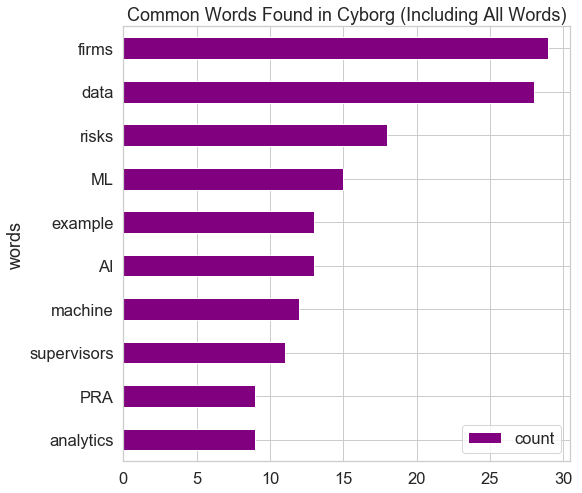

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
freq_df_1.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Cyborg (Including All Words)")

plt.show()

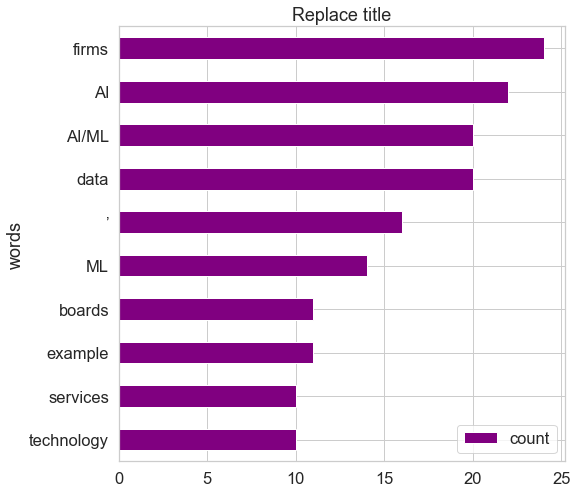

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
freq_df_2.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Replace title")

plt.show()

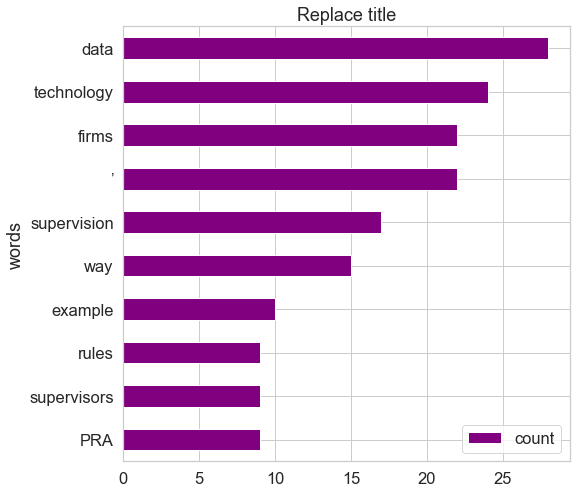

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
freq_df_3.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Replace title")

plt.show()

# Collocation

In [62]:
#extracting bigrams and trigrams
for doc in documents2:
    words = doc.lower().split()
    words_clean = [x for x in words if x not in stop_words and (x != '–') and (x != '-')]
    bigram_collocation = BigramCollocationFinder.from_words(words_clean)
    print('Top 10 bigrams:')
    print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 10))
    
    trigram_collocation = TrigramCollocationFinder.from_words(words_clean) 
    print('Top 10 trigrams:')
    print(trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 10))
    print('-------' * 10)

Top 10 bigrams:
[('advanced', 'analytics'), ('machine', 'learning'), ('safety', 'soundness'), ('key', 'risks'), ('supervisory', 'strategy'), ('risks', 'safety'), ('letters', 'write'), ('non-linear', 'relationships'), ('want', 'explore'), ('parts', 'rulebook')]
Top 10 trigrams:
[('adoption', 'advanced', 'analytics'), ('advanced', 'analytics', 'assist.'), ('advanced', 'analytics', 'broadly,'), ('advanced', 'analytics', 'opening'), ('controlled.', 'advanced', 'analytics'), ('demonstrate', 'advanced', 'analytics'), ('development', 'advanced', 'analytics'), ('environment.', 'advanced', 'analytics'), ('work.', 'advanced', 'analytics'), ('advanced', 'analytics', 'across')]
----------------------------------------------------------------------
Top 10 bigrams:
[('per', 'cent'), ('artificial', 'intelligence'), ('financial', 'services'), ('ai', 'ml'), ('challenge', 'posed'), ('introduction', 'ai/ml'), ('bank', 'england'), ('need', 'understand'), ('skill', 'sets'), ('machine', 'learning')]
Top 10 

In [63]:
bi_tri_grams_1 = pd.DataFrame(columns = ['Bigrams', 'Trigrams'])
words = documents2[0].lower().split()
words_clean = [x for x in words if x not in stop_words and (x != '–') and (x != '-')]
bigram_collocation = BigramCollocationFinder.from_words(words_clean)
trigram_collocation = TrigramCollocationFinder.from_words(words_clean) 
bi_tri_grams_1['Bigrams'] = bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5)
bi_tri_grams_1['Trigrams'] = trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5)
bi_tri_grams_1

,Bigrams,Trigrams
0,"(advanced, analytics)","(adoption, advanced, analytics)"
1,"(machine, learning)","(advanced, analytics, assist.)"
2,"(safety, soundness)","(advanced, analytics, broadly,)"
3,"(key, risks)","(advanced, analytics, opening)"
4,"(supervisory, strategy)","(controlled., advanced, analytics)"


In [94]:
bi_tri_grams_1.to_csv('bi_tri_grams_1.csv')

In [64]:
bi_tri_grams_2 = pd.DataFrame(columns = ['Bigrams', 'Trigrams'])
words = documents2[1].lower().split()
words_clean = [x for x in words if x not in stop_words and (x != '–') and (x != '-')]
bigram_collocation = BigramCollocationFinder.from_words(words_clean)
trigram_collocation = TrigramCollocationFinder.from_words(words_clean) 
bi_tri_grams_2['Bigrams'] = bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5)
bi_tri_grams_2['Trigrams'] = trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5)
bi_tri_grams_2

,Bigrams,Trigrams
0,"(per, cent)","(per, cent, reported)"
1,"(artificial, intelligence)","(applications,, per, cent)"
2,"(financial, services)","(banking,, per, cent)"
3,"(ai, ml)","(deployment,, per, cent)"
4,"(challenge, posed)","(engagement,, per, cent)"


In [96]:
bi_tri_grams_2.to_csv('bi_tri_grams_2.csv')

In [65]:
bi_tri_grams_3 = pd.DataFrame(columns = ['Bigrams', 'Trigrams'])
words = documents2[2].lower().split()
words_clean = [x for x in words if x not in stop_words and (x != '–') and (x != '-')]
bigram_collocation = BigramCollocationFinder.from_words(words_clean)
trigram_collocation = TrigramCollocationFinder.from_words(words_clean) 
bi_tri_grams_3['Bigrams'] = bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5)
bi_tri_grams_3['Trigrams'] = trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 5)
bi_tri_grams_3

,Bigrams,Trigrams
0,"(safety, soundness)","(safety, soundness, regulated)"
1,"(advances, technology)","(promoting, safety, soundness)"
2,"(social, media)","(safety, soundness, always)"
3,"(bigbank’s, smallbank’s)","(safety, soundness, evaluate)"
4,"((e., g.)","(safety, soundness, objective,)"


In [98]:
bi_tri_grams_3.to_csv('bi_tri_grams_3.csv')

In [66]:
tfile = open('doc1.txt', 'a')
tfile.write(df['Speech'][0])
tfile.close()

In [67]:
tfile = open('doc2.txt', 'a')
tfile.write(df['Speech'][1])
tfile.close()

In [68]:
tfile = open('doc3.txt', 'a')
tfile.write(df['Speech'][2])
tfile.close()

## Lexical dispersion analysis 

In [69]:
textList1 = Text(nltk.corpus.gutenberg.words('doc1.txt'))

In [70]:
#looking for the contexts of a given word
textList1.concordance("machine")

Displaying 12 of 12 matches:
 intelligence ( AI ) - the use of a machine to simulate human behaviour â  an
man behaviour â  and its subset , machine learning ( ML ) â  in which a mac
ine learning ( ML ) â  in which a machine teaches itself to perform tasks â 
faced in developing AI . Enabling a machine to teach itself to recognise a face
rest and investment in automation , machine learning and artificial intelligenc
. Increasing levels of automation , machine learning and AI could improve the s
ilable and can be used for training machine learning models . Recent research ,
on - linear relationships for which machine learning models are well suited . M
rvision is amenable to automation , machine learning or AI to some extent . Wit
ness of data . The idea is based on machine readablereporting requirements that
mit that data request to firms in a machine readable form . The data would then
ent to firms . Advanced analytics , machine learning and AI seem to be everywhe


In [71]:
freq_df_1['words'][:5]

0    firms
1     data
2    risks
3       ML
4       AI
Name: words, dtype: object

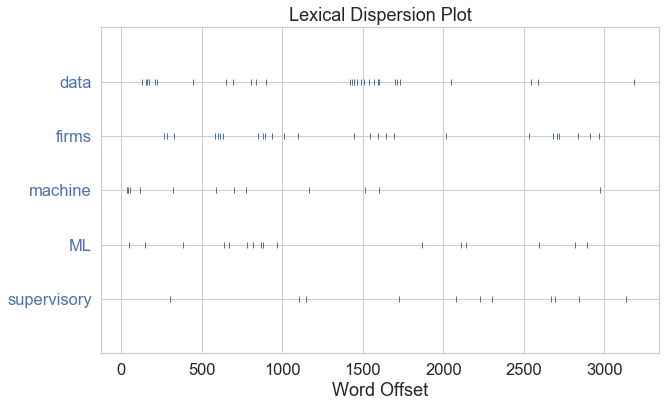

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
textList1.dispersion_plot(['data', 'firms', 'machine', 'ML', 'supervisory'])

[nltk_data] Downloading package webtext to /Users/Mada/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


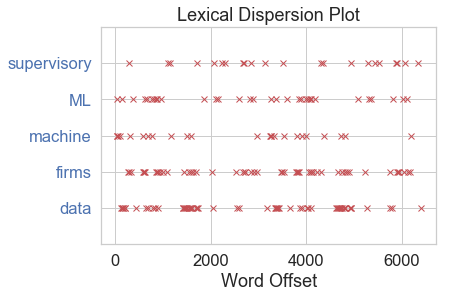

In [96]:
import matplotlib.pyplot as plt

words = ['data', 'firms', 'machine', 'ML', 'supervisory']
 
nltk.download('webtext')
wt_words = webtext.words('doc1.txt')  # Sample data
 
points = [(x, y) for x in range(len(wt_words))
          for y in range(len(words)) if wt_words[x] == words[y]]
 
if points:
    x, y = zip(*points)
else:
    x = y = ()

plt.plot(x, y, "rx", scalex=.1)
plt.yticks(range(len(words)), words, color="b")
plt.ylim(-1, len(words))
plt.title("Lexical Dispersion Plot")
plt.xlabel("Word Offset")
plt.show()

In [97]:
points = [(x, words[y]) for x in range(len(wt_words))
          for y in range(len(words)) if wt_words[x] == words[y]]
points

[(33, 'machine'),
 (44, 'machine'),
 (47, 'ML'),
 (54, 'machine'),
 (113, 'machine'),
 (128, 'data'),
 (149, 'ML'),
 (154, 'data'),
 (160, 'data'),
 (171, 'data'),
 (207, 'data'),
 (220, 'data'),
 (264, 'firms'),
 (284, 'firms'),
 (301, 'supervisory'),
 (320, 'machine'),
 (329, 'firms'),
 (384, 'ML'),
 (445, 'data'),
 (581, 'firms'),
 (590, 'machine'),
 (601, 'firms'),
 (613, 'firms'),
 (633, 'firms'),
 (636, 'ML'),
 (651, 'data'),
 (668, 'ML'),
 (691, 'data'),
 (700, 'machine'),
 (773, 'machine'),
 (780, 'ML'),
 (803, 'data'),
 (816, 'ML'),
 (834, 'data'),
 (850, 'firms'),
 (865, 'ML'),
 (879, 'firms'),
 (882, 'ML'),
 (894, 'firms'),
 (897, 'data'),
 (938, 'firms'),
 (965, 'ML'),
 (1013, 'firms'),
 (1098, 'firms'),
 (1101, 'supervisory'),
 (1146, 'supervisory'),
 (1164, 'machine'),
 (1420, 'data'),
 (1430, 'data'),
 (1444, 'firms'),
 (1447, 'data'),
 (1465, 'data'),
 (1487, 'data'),
 (1504, 'data'),
 (1511, 'machine'),
 (1538, 'data'),
 (1545, 'firms'),
 (1569, 'data'),
 (1592, 'data'

In [98]:
doc1_words = pd.DataFrame(points, columns = ['position', 'word'])
doc1_words.to_csv('lexical_dispersion1.csv')

In [69]:
freq_df_2['words'][:5]

0           ai
1        firms
2         data
3    financial
4        ai/ml
Name: words, dtype: object

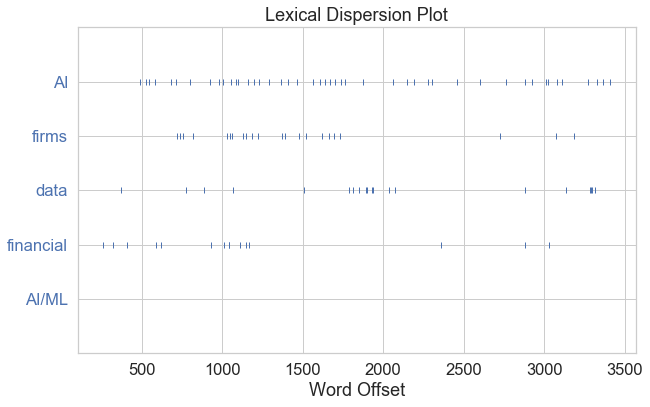

In [70]:
textList2 = Text(nltk.corpus.gutenberg.words('doc2.txt'))
fig, ax = plt.subplots(figsize=(10, 6))
textList2.dispersion_plot(['AI', 'firms', 'data', 'financial', 'AI/ML'])

[nltk_data] Downloading package webtext to /Users/Mada/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


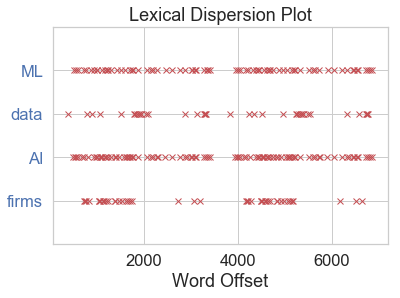

In [99]:
import matplotlib.pyplot as plt

words = ['firms', 'AI', 'data', 'ML']
 
nltk.download('webtext')
wt_words = webtext.words('doc2.txt')  # Sample data
 
points = [(x, y) for x in range(len(wt_words))
          for y in range(len(words)) if wt_words[x] == words[y]]
 
if points:
    x, y = zip(*points)
else:
    x = y = ()

plt.plot(x, y, "rx", scalex=.1)
plt.yticks(range(len(words)), words, color="b")
plt.ylim(-1, len(words))
plt.title("Lexical Dispersion Plot")
plt.xlabel("Word Offset")
plt.show()

In [100]:
points = [(x, words[y]) for x in range(len(wt_words))
          for y in range(len(words)) if wt_words[x] == words[y]]
points

[(375, 'data'),
 (488, 'AI'),
 (515, 'ML'),
 (526, 'AI'),
 (548, 'AI'),
 (550, 'ML'),
 (584, 'AI'),
 (586, 'ML'),
 (681, 'AI'),
 (717, 'AI'),
 (719, 'ML'),
 (722, 'firms'),
 (739, 'firms'),
 (756, 'firms'),
 (759, 'ML'),
 (774, 'data'),
 (802, 'AI'),
 (819, 'firms'),
 (861, 'ML'),
 (888, 'data'),
 (928, 'AI'),
 (930, 'ML'),
 (983, 'AI'),
 (985, 'ML'),
 (1003, 'AI'),
 (1005, 'ML'),
 (1033, 'firms'),
 (1047, 'firms'),
 (1057, 'AI'),
 (1062, 'firms'),
 (1066, 'data'),
 (1084, 'AI'),
 (1099, 'AI'),
 (1101, 'ML'),
 (1133, 'firms'),
 (1150, 'firms'),
 (1162, 'AI'),
 (1164, 'ML'),
 (1188, 'firms'),
 (1198, 'AI'),
 (1200, 'ML'),
 (1221, 'firms'),
 (1230, 'AI'),
 (1232, 'ML'),
 (1292, 'AI'),
 (1294, 'ML'),
 (1369, 'AI'),
 (1372, 'firms'),
 (1388, 'firms'),
 (1411, 'AI'),
 (1419, 'ML'),
 (1466, 'AI'),
 (1475, 'firms'),
 (1508, 'data'),
 (1516, 'ML'),
 (1524, 'firms'),
 (1563, 'AI'),
 (1584, 'ML'),
 (1606, 'AI'),
 (1618, 'firms'),
 (1638, 'AI'),
 (1665, 'firms'),
 (1668, 'AI'),
 (1697, 'firms'),


In [101]:
doc2_words = pd.DataFrame(points, columns = ['position', 'word'])
doc2_words.to_csv('lexical_dispersion2.csv')

In [71]:
freq_df_3['words'][:5]

0           data
1     technology
2     prudential
3    supervision
4            way
Name: words, dtype: object

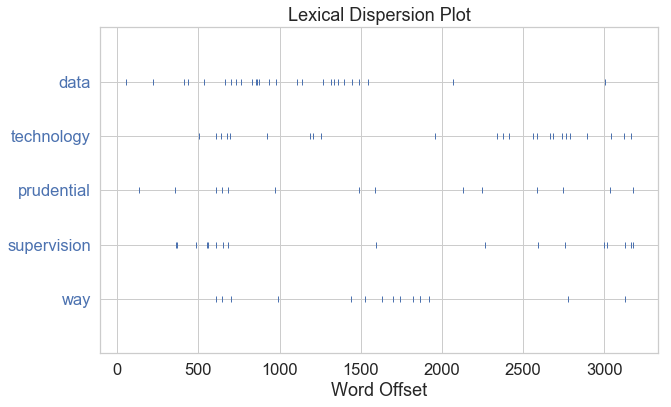

In [72]:
textList3 = Text(nltk.corpus.gutenberg.words('doc3.txt'))
fig, ax = plt.subplots(figsize=(10, 6))
textList3.dispersion_plot(['data', 'technology', 'prudential', 'supervision', 'way'])

[nltk_data] Downloading package webtext to /Users/Mada/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


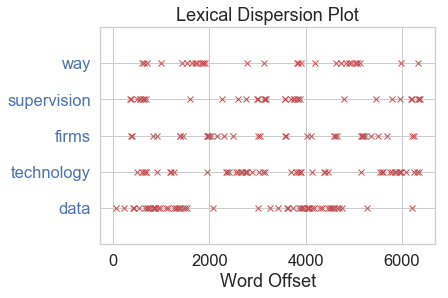

In [105]:
import matplotlib.pyplot as plt

words = ['data', 'technology', 'firms', 'supervision', 'way']
 
nltk.download('webtext')
wt_words = webtext.words('doc3.txt')  # Sample data
 
points = [(x, y) for x in range(len(wt_words))
          for y in range(len(words)) if wt_words[x] == words[y]]
 
if points:
    x, y = zip(*points)
else:
    x = y = ()

plt.plot(x, y, "rx", scalex=.1)
plt.yticks(range(len(words)), words, color="b")
plt.ylim(-1, len(words))
plt.title("Lexical Dispersion Plot")
plt.xlabel("Word Offset")
plt.show()

In [106]:
points = [(x, words[y]) for x in range(len(wt_words))
          for y in range(len(words)) if wt_words[x] == words[y]]
points

[(55, 'data'),
 (222, 'data'),
 (362, 'supervision'),
 (367, 'supervision'),
 (379, 'firms'),
 (386, 'firms'),
 (413, 'data'),
 (440, 'data'),
 (489, 'supervision'),
 (504, 'technology'),
 (535, 'data'),
 (552, 'supervision'),
 (562, 'supervision'),
 (607, 'technology'),
 (611, 'way'),
 (613, 'supervision'),
 (640, 'technology'),
 (646, 'way'),
 (652, 'supervision'),
 (664, 'data'),
 (679, 'technology'),
 (682, 'supervision'),
 (695, 'technology'),
 (700, 'data'),
 (703, 'way'),
 (733, 'data'),
 (765, 'data'),
 (824, 'firms'),
 (831, 'data'),
 (855, 'data'),
 (864, 'data'),
 (877, 'data'),
 (908, 'firms'),
 (923, 'technology'),
 (934, 'data'),
 (982, 'data'),
 (990, 'way'),
 (1107, 'data'),
 (1141, 'data'),
 (1187, 'technology'),
 (1210, 'technology'),
 (1259, 'technology'),
 (1268, 'data'),
 (1315, 'data'),
 (1337, 'data'),
 (1362, 'data'),
 (1386, 'firms'),
 (1398, 'data'),
 (1401, 'firms'),
 (1439, 'way'),
 (1445, 'data'),
 (1461, 'firms'),
 (1488, 'data'),
 (1528, 'way'),
 (1546, '

In [107]:
doc3_words = pd.DataFrame(points, columns = ['position', 'word'])
doc3_words.to_csv('lexical_dispersion3.csv')

In [108]:
pd.__version__

'0.25.0'

# TF-IDF

In [73]:
documentA = df['Speech'][0]
documentB = df['Speech'][1]
documentC = df['Speech'][2]

In [74]:
uniqueWords = []
uniqueWords.append(documentA)
uniqueWords.append(documentB)
uniqueWords.append(documentC)

In [75]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(uniqueWords)
names = vectorizer.get_feature_names()
data = vectors.todense().tolist()

In [76]:
# Create a dataframe with the results
dff = pd.DataFrame(data, columns=names)
dff = dff[filter(lambda x: x not in list(stop_words) , dff.columns)]
N = 10;
for i in dff.iterrows():
    print(i[1].sort_values(ascending=False)[:N])

data           0.095827
firms          0.095827
ml             0.065811
risks          0.057496
supervisory    0.045245
supervisors    0.041525
ai             0.041525
example        0.041525
rulebook       0.041132
machine        0.038331
Name: 0, dtype: float64
ml           0.151126
ai           0.145910
firms        0.085643
data         0.072955
survey       0.053706
financial    0.050751
boards       0.041235
use          0.040845
outcomes     0.040845
cent         0.037594
Name: 1, dtype: float64
data           0.105903
technology     0.088252
supervision    0.081822
firms          0.077662
prudential     0.052951
way            0.052951
regulatory     0.042361
question       0.041839
might          0.040911
pra            0.035301
Name: 2, dtype: float64


### Entity recognition

In [77]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [81]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
iob_tagged = tree2conlltags(cs)

In [82]:
from nltk.chunk import ne_chunk
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/Mada/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/Mada/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [87]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [144]:
sent = preprocess(df['Speech'][1])
pattern = 'NP: {<DT>?<JJ>*<NN>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)

In [145]:
ex = df['Speech'][1]
ne_tree = ne_chunk(pos_tag(word_tokenize(ex)))

In [146]:
doc = nlp(ex)

In [147]:
speech = nlp(ex)
len(speech.ents)

73

In [148]:
labels = [x.label_ for x in speech.ents]
Counter(labels)

Counter({'CARDINAL': 17,
         'DATE': 9,
         'GPE': 8,
         'ORG': 22,
         'ORDINAL': 14,
         'PERSON': 2,
         'FAC': 1})

In [149]:
items = [x.text for x in speech.ents]
Counter(items).most_common(15)

[('three', 6),
 ('UK', 5),
 ('the Bank of England', 3),
 ('first', 3),
 ('third', 3),
 ('one', 2),
 ('two', 2),
 ('AML', 2),
 ('McKinsey', 2),
 ('FCA', 2),
 ('First', 2),
 ('Second', 2),
 ('Bank', 2),
 ('one to five', 1),
 ('a year', 1)]

In [ ]:
sentences = [x for x in speech.sents]
print(sentences[4])

In [ ]:
displacy.render(nlp(str(sentences[4])), style='dep', jupyter = True, options = {'distance': 120})

In [138]:
entities1 = pd.DataFrame(columns = ['Word', 'Entity' ,'Occurrance'])

In [142]:
e1 = Counter(items).most_common(5)
a1 = [word for (word, number) in e1]
b1 = ['ORG', 'ORDINAL', 'WORK OF ART', 'CARDINAL', 'CARDINAL']
c1 = [number for (word, number) in e1]

In [143]:
entities1['Word'] = a1
entities1['Entity'] = b1
entities1['Occurrance'] = c1
entities1

,Word,Entity,Occurrance
0,PRA,ORG,7
1,one,ORDINAL,3
2,Rulebook,WORK OF ART,2
3,second,CARDINAL,2
4,third,CARDINAL,2


In [155]:
entities1.to_csv('Entity rec1.csv')

In [151]:
displacy.render(nlp(str(ex)), jupyter=True, style='ent')